In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/hpc/caph/mppi045h/gammapy/gammapy/__init__.py'>


$\mathcal{L} = \exp(-\lambda) \frac{1}{n!} \lambda ^n$ \
for easier minimalisation: \
$-2 \log (\mathcal{L})= - 2 n \log (\lambda) + 2 \lambda $

In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
penality 0 []
MapDataset
----------

  Name                            : lnseLdQ0 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Tem

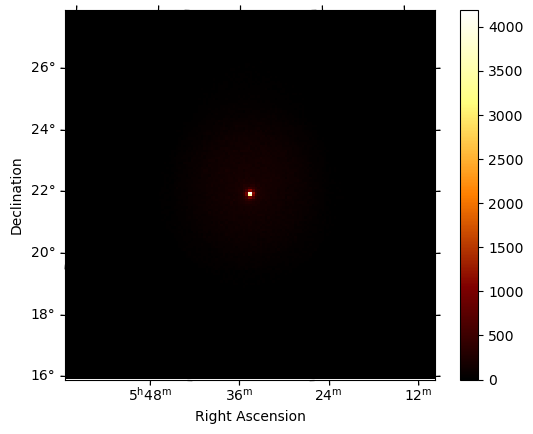

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models([source_model])

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy(name="Source"))
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Asimov Cases

In [4]:
factor_neg = -0.1
factor_pos = +0.1

sigma = 0.1

in modelbase:

def __init_subclass__(cls, **kwargs):
        # Add parameters list on the model sub-class (not instances)
        cls.default_parameters = Parameters(
            [_ for _ in cls.__dict__.values() if isinstance(_, Parameter)]
        )
        
        

In [5]:
sys_d_cor = sys_dataset(dataset_asimov, 0, False)
dataset_cor_N = sys_d_cor.create_dataset_N(sigma)

sys_d_neg = sys_dataset(dataset_asimov, factor_neg, False)
dataset_neg_N = sys_d_neg.create_dataset_N(sigma)

sys_d_pos = sys_dataset(dataset_asimov, factor_pos, False)
dataset_pos_N = sys_d_pos.create_dataset_N(sigma)


#penalising_covmatrix = [[sigma,sigma * 0.99], [sigma * 0.99, sigma]]
#penalising_covmatrix = [[sigma, 0.5], [0.5, sigma]]

#penalising_invcovmatrix = np.linalg.inv(penalising_covmatrix)

sigma_a = 0.1
sigma_n = 0.1
#sigma_na = 0.9
sigma_na = 0.01

penalising_covmatrix = [[1/sigma_a**2 + 1/sigma_na ** 2,  - 1/sigma_na**2],
                        [  - 1/sigma_na**2             ,    1/sigma_n**2 + 1/sigma_na ** 2]]

penalising_invcovmatrix =  penalising_covmatrix

dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets  = [dataset_pos_N, dataset_cor_N, dataset_neg_N]

for d in datasets:
    for par in ['norm_nuisance', 'amplitude_nuisance']:
        d.models.parameters[par].max = 0.2
        d.models.parameters[par].min = -0.2
    #d.models.parameters['norm_nuisance'].frozen = True


print(dataset_neg_N)

4
4
4
4
4
4
penality 0.0 [0. 0.]
MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 361333 
  Total background counts         : 396364.47
  Total excess counts             : -35031.40

  Predicted counts                : 281392.63
  Predicted background counts     : 280290.73
  Predicted excess counts         : 1101.90

  Exposure min                    : 2.28e-01 m2 s
  Exposure max                    : 2.65e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -538731.50

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 9

  Component 0: SkyModel
  
    Name                      : SourceN
    Datasets names            : None
    Spectral model type       : PowerLawNuisanceSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Tem

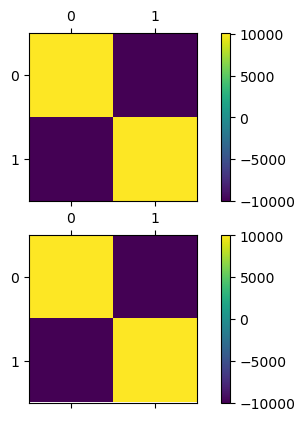

In [6]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_covmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

corr
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 92.8589342146358 [0.09588511 0.        ]
penality 92.8589342146358 [-0.09588511  0.        ]
penality 1.0091586138387956 [0.00999583 0.        ]
penality 1.0091586138387956 [-0.00999583  0.        ]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 92.8589342146358 [0.         0.09588511]
penality 92.8589342146358 [ 0.         -0.09588511]
penality 1.0091586138387956 [0.         0.00999583]
penality 1.0091586138387956 [ 0.         -0.00999583]
penality 0.0

penality 8.95550228904529 [-0.03147015 -0.00171083]
penality 8.95550228904529 [-0.03147015 -0.00171083]
penality 8.95550228904529 [-0.03147015 -0.00171083]
penality 8.95550228904529 [-0.03147015 -0.00171083]
penality 8.95550228904529 [-0.03147015 -0.00171083]
penality 8.95550228904529 [-0.03147015 -0.00171083]
penality 9.373699071072961 [-0.03147015 -0.00101599]
penality 8.547070062394612 [-0.03147015 -0.00240565]
penality 8.95550228904529 [-0.03147015 -0.00171083]
penality 8.95550228904529 [-0.03147015 -0.00171083]
penality 8.170854636992853 [-0.03037675 -0.00195457]
penality 5.388200232630063 [-0.02599416 -0.00292953]
penality 3.998093901568 [-0.02336755 -0.00351243]
penality 4.22368891179139 [-0.0238219  -0.00341167]
penality 4.22368891179139 [-0.0238219  -0.00341167]
penality 4.22368891179139 [-0.0238219  -0.00341167]
penality 4.22368891179139 [-0.0238219  -0.00341167]
penality 4.22368891179139 [-0.0238219  -0.00341167]
penality 4.22368891179139 [-0.0238219  -0.00341167]
penality 4

penality 0.0008886244830993506 [-0.00210862 -0.00210707]
penality 0.0008886244830993506 [-0.00210862 -0.00210707]
penality 0.0008886244830993506 [-0.00210862 -0.00210707]
penality 0.0008886244830993506 [-0.00210862 -0.00210707]
penality 0.0008886244830993506 [-0.00210862 -0.00210707]
penality 0.0008886244830993506 [-0.00210862 -0.00210707]
penality 0.0008886244830993506 [-0.00210862 -0.00210707]
penality 0.00550586253565386 [-0.00210862 -0.00141133]
penality 0.006048734494560617 [-0.00210862 -0.00280278]
penality 0.0008886244830993506 [-0.00210862 -0.00210707]
penality 0.0008886244830993506 [-0.00210862 -0.00210707]
penality 0.0008845625958849301 [-0.00208689 -0.00210827]
penality 0.0008858501863453796 [-0.00210044 -0.00210752]
penality 0.0008872161708928743 [-0.00210501 -0.00210727]
penality 0.0008879286916263887 [-0.00210693 -0.00210716]
penality 0.0008882821729084252 [-0.00210781 -0.00210711]
penality 0.0008884561729527849 [-0.00210822 -0.00210709]
penality 0.0008885416135188454 [-0

penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 92.8589342146358 [0.09588511 0.        ]
penality 92.8589342146358 [-0.09588511  0.        ]
penality 1.0091586138387956 [0.00999583 0.        ]
penality 1.0091586138387956 [-0.00999583  0.        ]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 92.8589342146358 [0.         0.09588511]
penality 92.8589342146358 [ 0.         -0.09588511]
penality 1.0091586138387956 [0.         0.00999583]
penality 1.0091586138387956 [ 0.         -0.00999583]
penality 0.0 [0. 

penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5779016486222869 [-0.04861737 -0.04487338]
penality 0.5080684507142663 [-0.04861737 -0.04620454]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.5384968412045036 [-0.04861737 -0.04553922]
penality 0.4230104659335579 [-0.04441151 -0.04570918]
penality 1.0947289456022413 

penality 0.408258408959888 [-0.04490023 -0.04529105]
penality 0.408258408959888 [-0.04490023 -0.04529105]
penality 0.408258408959888 [-0.04490023 -0.04529105]
penality 0.408258408959888 [-0.04490023 -0.04529105]
penality 0.408258408959888 [-0.04490023 -0.04529105]
penality 0.4014976069183417 [-0.04490023 -0.04462439]
penality 0.42398082145268007 [-0.04490023 -0.04595718]
penality 0.408258408959888 [-0.04490023 -0.04529105]
penality 0.408258408959888 [-0.04490023 -0.04529105]
penality 0.40812440842870773 [-0.04488977 -0.04528382]
penality 0.40790253469715787 [-0.04487239 -0.04527183]
penality 0.40805279192520716 [-0.04488416 -0.04527996]
penality 0.40805279192520716 [-0.04488416 -0.04527996]
penality 0.40805279192520716 [-0.04488416 -0.04527996]
penality 0.40805279192520716 [-0.04488416 -0.04527996]
penality 0.40805279192520716 [-0.04488416 -0.04527996]
penality 0.5794953349618573 [-0.04071129 -0.04527996]
penality 0.5866061931016919 [-0.04903656 -0.04527996]
penality 0.4080527919252071

penality 0.15758892529574983 [-0.0279566  -0.02813016]
penality 0.15758892529574983 [-0.0279566  -0.02813016]
penality 0.15758892529574983 [-0.0279566  -0.02813016]
penality 0.15758892529574983 [-0.0279566  -0.02813016]
penality 0.15758892529574983 [-0.0279566  -0.02813016]
penality 0.15758892529574983 [-0.0279566  -0.02813016]
penality 0.15758892529574983 [-0.0279566  -0.02813016]
penality 0.1560607604797012 [-0.0279566  -0.02745283]
penality 0.16837664170277677 [-0.0279566  -0.02880715]
penality 0.15758892529574983 [-0.0279566  -0.02813016]
penality 0.15758892529574983 [-0.0279566  -0.02813016]
penality 0.15460305449622844 [-0.02764383 -0.02786997]
penality 0.1511254894905016 [-0.02726724 -0.02755672]
penality 0.146383634247884 [-0.02672966 -0.02710957]
penality 0.146383634247884 [-0.02672966 -0.02710957]
penality 0.146383634247884 [-0.02672966 -0.02710957]
penality 0.146383634247884 [-0.02672966 -0.02710957]
penality 0.146383634247884 [-0.02672966 -0.02710957]
penality 0.33177547073

penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 0.004736383286523629 [0.00037985 0.00105881]
penality 0.005149103382573289 [ 0.00037985 -0.00033592]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 0.17728750995643877 [0.00454722 0.00036145]
penality 0.1735996376528158 [-0.00378767  0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.088168893549665e-05 [0.00037985 0.00036145]
penality 3.08

penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 92.8589342146358 [0.         0.09588511]
penality 92.8589342146358 [ 0.         -0.09588511]
penality 1.0091586138387956 [0.         0.00999583]
penality 1.0091586138387956 [ 0.         -0.00999583]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0

penality 3.9557770726073094 [0.06602957 0.04789   ]
penality 3.9557770726073094 [0.06602957 0.04789   ]
penality 3.9557770726073094 [0.06602957 0.04789   ]
penality 3.7033952707384468 [0.06602957 0.04861976]
penality 4.21916544398227 [0.06602957 0.04715957]
penality 3.9557770726073094 [0.06602957 0.04789   ]
penality 3.9557770726073094 [0.06602957 0.04789   ]
penality 4.426596959645086 [0.06718719 0.04783157]
penality 6.595499145386851 [0.07179189 0.04759781]
penality 13.105930433225836 [0.08201552 0.04707025]
penality 10.09960169006291 [0.07774158 0.04729233]
penality 10.09960169006291 [0.07774158 0.04729233]
penality 10.09960169006291 [0.07774158 0.04729233]
penality 10.09960169006291 [0.07774158 0.04729233]
penality 10.09960169006291 [0.07774158 0.04729233]
penality 10.09960169006291 [0.07774158 0.04729233]
penality 10.09960169006291 [0.07774158 0.04729233]
penality 10.09960169006291 [0.07774158 0.04729233]
penality 10.09960169006291 [0.07774158 0.04729233]
penality 12.8606376094556

penality 0.4478852841464468 [0.04673851 0.04741682]
penality 0.4478852841464468 [0.04673851 0.04741682]
penality 0.470053232646531 [0.04673851 0.04814575]
penality 0.43644478612155524 [0.04673851 0.04668722]
penality 0.4478852841464468 [0.04673851 0.04741682]
penality 0.4478852841464468 [0.04673851 0.04741682]
penality 0.44655733625582533 [0.04674417 0.04735845]
penality 0.4471652383603391 [0.04674154 0.04738562]
penality 0.4470011294698732 [0.04674224 0.04737836]
penality 0.4470011294698732 [0.04674224 0.04737836]
penality 0.4470011294698732 [0.04674224 0.04737836]
penality 0.4470011294698732 [0.04674224 0.04737836]
penality 0.4470011294698732 [0.04674224 0.04737836]
penality 0.6077857332538923 [0.05090266 0.04737836]
penality 0.6377447882948989 [0.04256031 0.04737836]
penality 0.4470011294698732 [0.04674224 0.04737836]
penality 0.4470011294698732 [0.04674224 0.04737836]
penality 0.4470011294698732 [0.04674224 0.04737836]
penality 0.4470011294698732 [0.04674224 0.04737836]
penality 0.

penality 0.1941572774461909 [0.03096996 0.03123313]
penality 0.20823550900631813 [0.03096996 0.03197427]
penality 0.1911761070653413 [0.03096996 0.03049155]
penality 0.1941572774461909 [0.03096996 0.03123313]
penality 0.1941572774461909 [0.03096996 0.03123313]
penality 0.13382562969475625 [0.02575452 0.02592441]
penality 0.1278781854691858 [0.02518106 0.02534066]
penality 0.08353514668315414 [0.02039371 0.02046723]
penality 0.08353514668315414 [0.02039371 0.02046723]
penality 0.08353514668315414 [0.02039371 0.02046723]
penality 0.08353514668315414 [0.02039371 0.02046723]
penality 0.08353514668315414 [0.02039371 0.02046723]
penality 0.2721715656842618 [0.02458819 0.02046723]
penality 0.25103844113713636 [0.01619014 0.02046723]
penality 0.08353514668315414 [0.02039371 0.02046723]
penality 0.08353514668315414 [0.02039371 0.02046723]
penality 0.08353514668315414 [0.02039371 0.02046723]
penality 0.08353514668315414 [0.02039371 0.02046723]
penality 0.08353514668315414 [0.02039371 0.02046723]

penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 0.004754006312095348 [-0.00031542  0.00037235]
penality 0.005124611804656813 [-0.00031542 -0.00102323]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240083437375e-05 [-0.00031542 -0.00032544]
penality 2.1545240

CPU times: user 25.9 s, sys: 250 ms, total: 26.1 s
Wall time: 26 s


<AxesSubplot: >

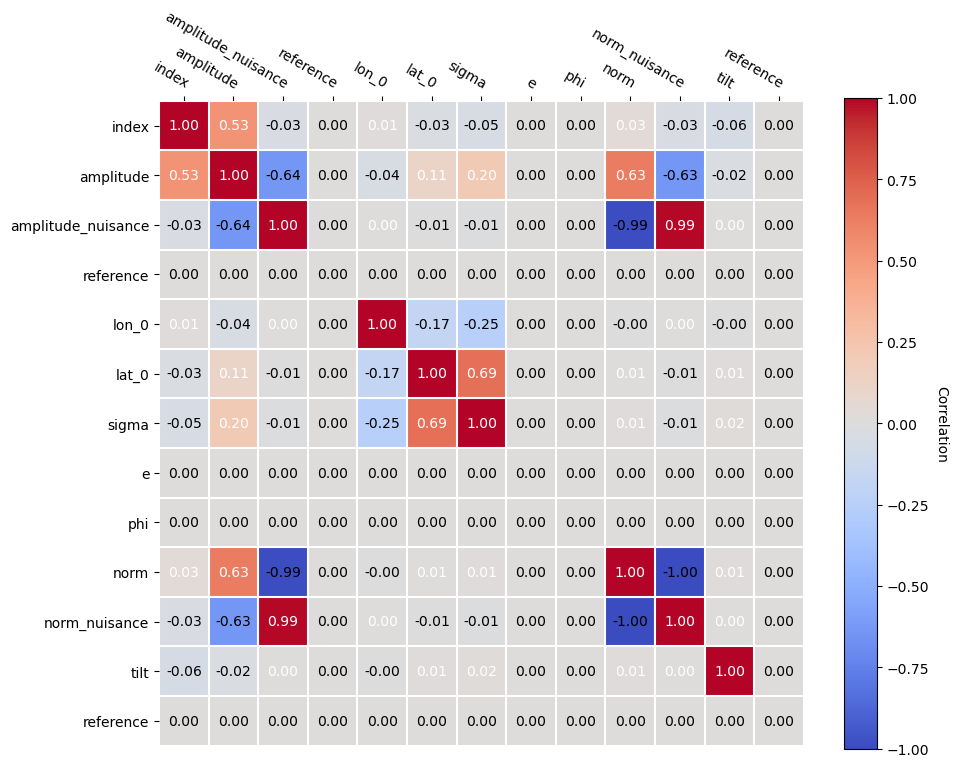

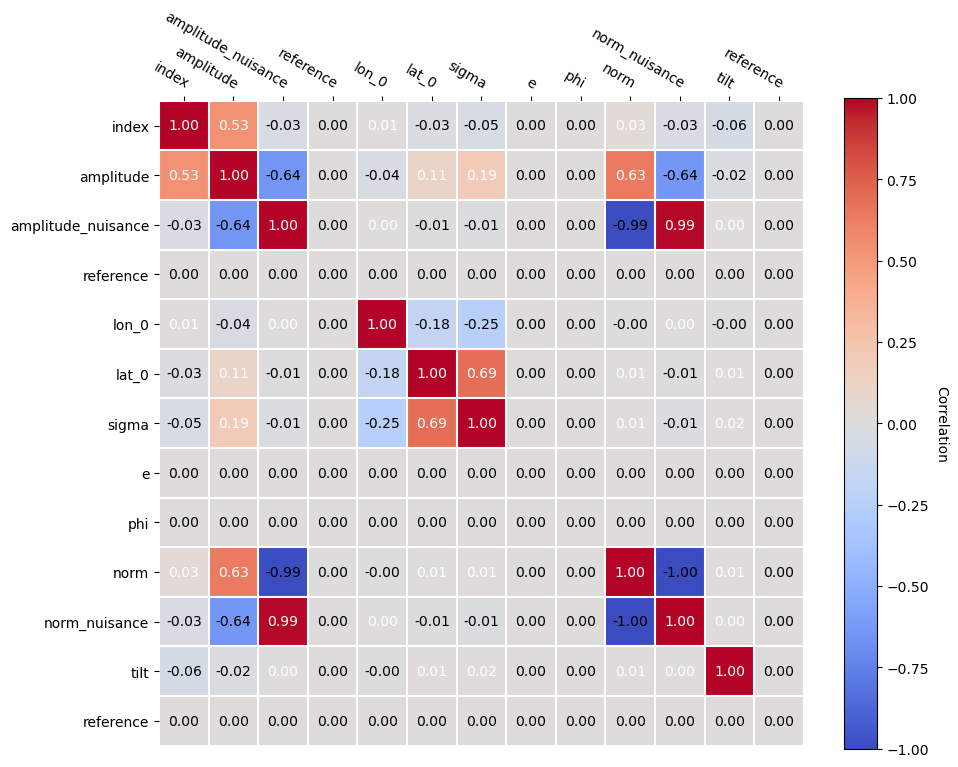

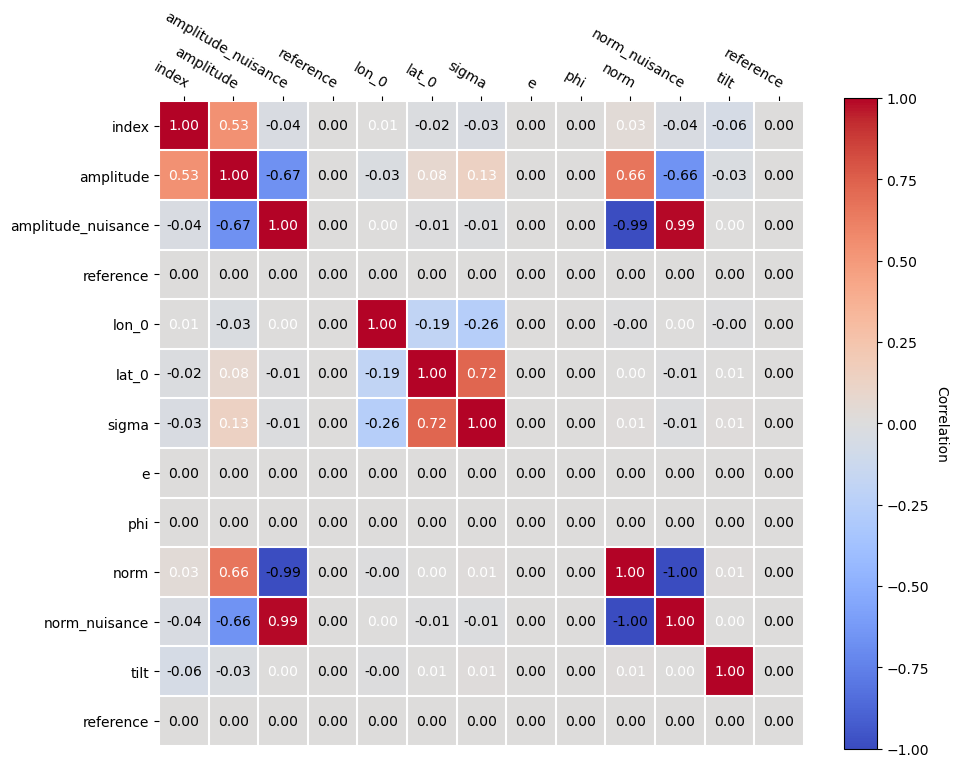

In [7]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run(dataset_cor_N)
        
print("neg")
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run(dataset_neg_N)

print("pos")
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run(dataset_pos_N)


dataset_pos_N.models.covariance = fit_pos.covariance(dataset_pos_N).matrix
dataset_pos_N.models.covariance.plot_correlation()

dataset_neg_N.models.covariance = fit_neg.covariance(dataset_neg_N).matrix
dataset_neg_N.models.covariance.plot_correlation()

dataset_cor_N.models.covariance = fit_cor.covariance(dataset_cor_N).matrix
dataset_cor_N.models.covariance.plot_correlation()

In [8]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
print("best fit amplitude")
amplitudes_N = []
m = dataset_asimov.models[0]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices_N = []
m = dataset_asimov.models[0]
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms_N = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms_N.append((value, error))
    

best fit amplitude
====
Input
1e-12 pm 0.0
====
9.119652052993864e-13 pm 1.098402452113294e-13
1.0038119108063774e-12 pm 1.2287455471693614e-13
1.115214457406403e-12 pm 1.3431008918752316e-13

best fit Index
====
Input
2.3 pm 0.0
====
2.3005642220284788 pm 0.06182716540103528
2.3003359860904142 pm 0.06178682551506193
2.300263714155673 pm 0.061817969617017

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.9087642836975404 pm 0.06669428029046907
1.0021126792339914 pm 0.07804174308160207
1.1114673668013055 pm 0.0813727826682833


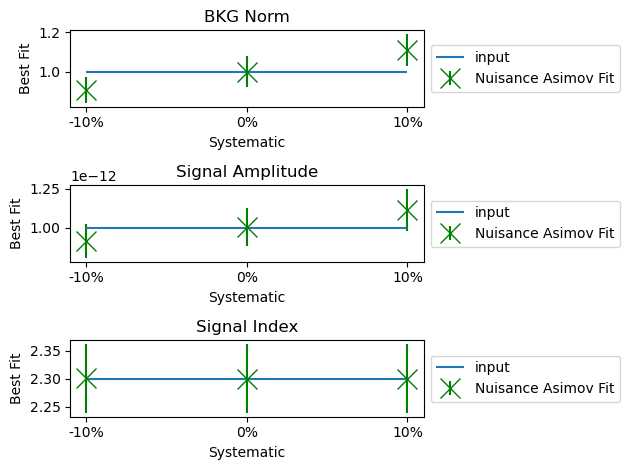

In [9]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
fig.savefig("best_fit_parameters_corr.pdf")   


index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance


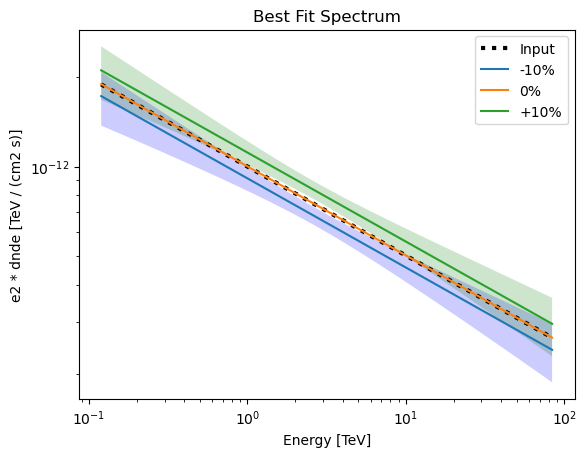

In [10]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

0.00037985371407600995 0.07341849828382058
-0.002108606846694161 0.07765206812711475
-0.00031541759891342403 0.07319753584343479
0.00036144585108449726 0.07339381722472176
-0.0021070683747005624 0.07769016043598424
-0.00032544304751045544 0.07316587758506149


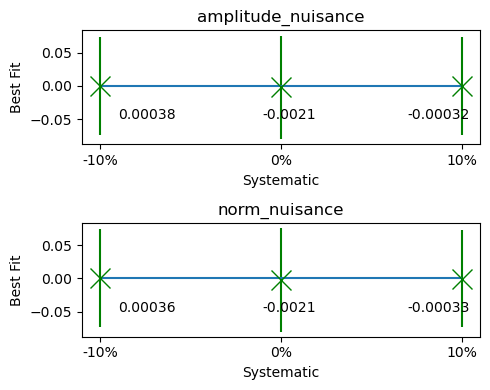

In [11]:
n_nui = len(dataset_neg_N.models.parameters.penalised_parameters)
fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for j, par_name in enumerate(dataset_neg_N.models.parameters.penalised_parameters.names):
    for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
        value = d.models.parameters[par_name].value
        error = d.models.parameters[par_name].error
        print(value, error)

        a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color =  'green',markersize=14,
                       label = label)
        a[j].text(iss[i],-0.05, f'{value:.2}', )
    a[j].hlines( 0., 1, 3, label = "input")

    a[j].set_ylabel('Best Fit' ); 
    a[j].set_title(par_name)
    a[j].set_xlabel('Systematic'); 
    a[j].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
#fig.savefig("plots/2_best_fit_nui.pdf")

## Comparison

In [12]:

with open('data/norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open('data/amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open('data/indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
    


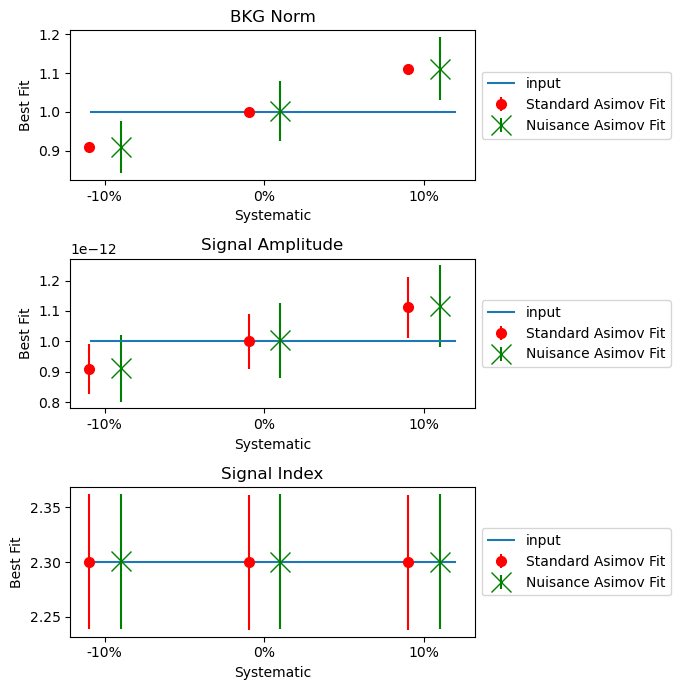

In [13]:
fig, axs = plt.subplots(3,1, figsize= (7, 7))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices[0][0], 0.91, 3.2, label = "input")
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   


### Spectrum

In [14]:
dataset_st_neg = dataset_neg_N.copy()
dataset_st_neg.models = Models.read("data/1_model_neg.yml")

dataset_st_pos = dataset_pos_N.copy()
dataset_st_pos.models = Models.read("data/1_model_pos.yml")

dataset_st_cor = dataset_cor_N.copy()
dataset_st_cor.models = Models.read("data/1_model_cor.yml")

In [15]:
#dataset_neg_N.models[0].spectral_model.parameters['amplitude_nuisance'].frozen = True

index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance
index
amplitude
index
amplitude
index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance
index
amplitude
index
amplitude
index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance
index
amplitude
index
amplitude


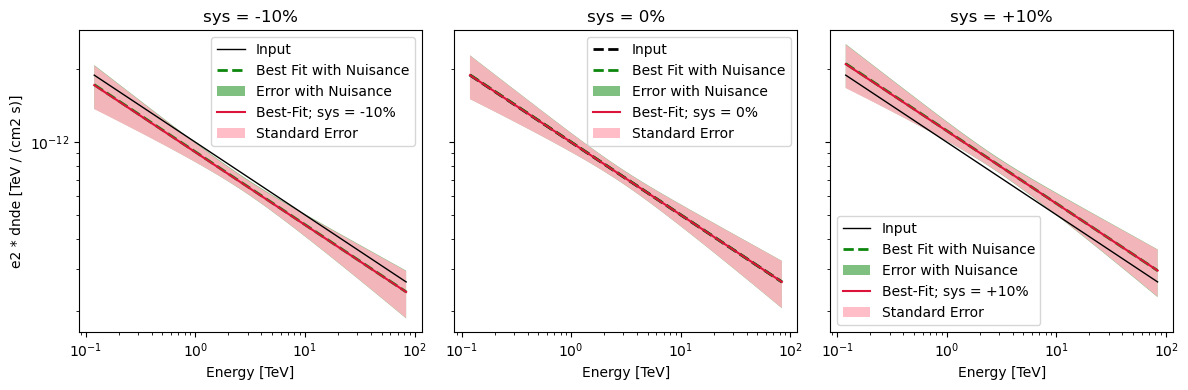

In [16]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### cor 
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                               label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)                                              

dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum.pdf")

<AxesSubplot: >

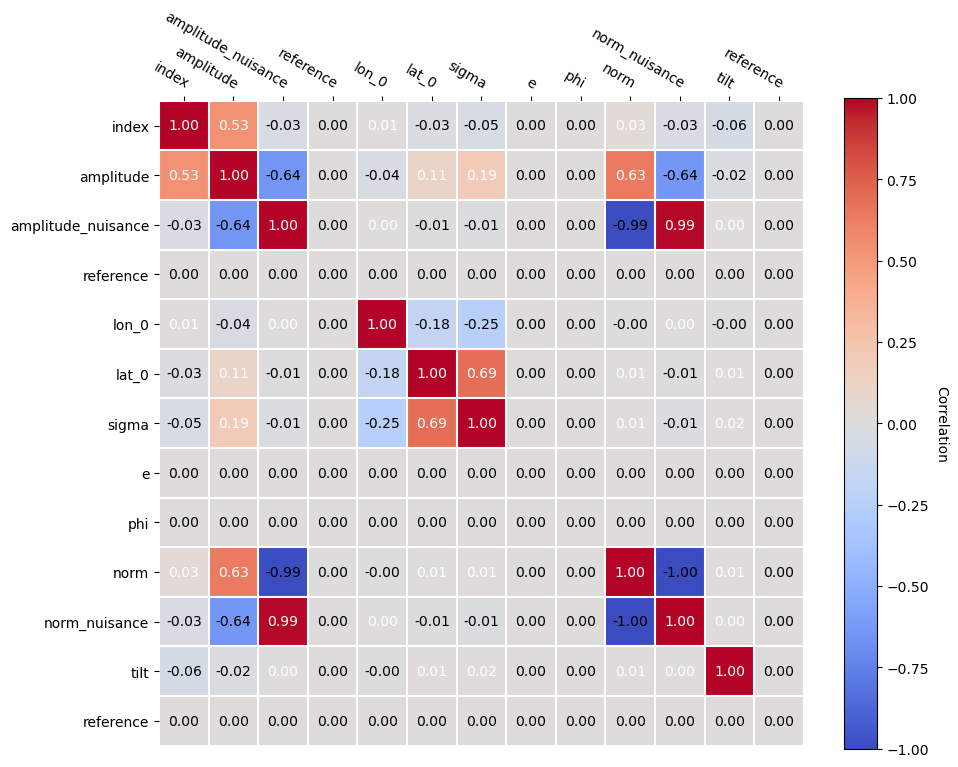

In [17]:
dataset_neg_N.models.covariance.plot_correlation()

In [18]:
from gammapy.stats import  gaussian_penality
values = np.linspace(-0.1, 0.1, 10)
pen = []
stat = []
for v in values:
    dataset_pos_N.models.parameters['norm_nuisance'].value = v
    dataset_pos_N.models.parameters['amplitude_nuisance'].value = v
    
    penalty = gaussian_penality(dataset_pos_N.models.parameters.penalised_parameters,
                                     dataset_pos_N._penalising_invcovmatrix)
    stat_sum = dataset_pos_N.stat_sum()  - penalty
    
    pen.append(penalty)
    stat.append(stat_sum)
pen = np.array(pen)
stat = np.array(stat)  



penality 2.0000000000000004 [-0.1 -0.1]
penality 1.2098765432098717 [-0.07777778 -0.07777778]
penality 0.6172839506172896 [-0.05555556 -0.05555556]
penality 0.22222222222222357 [-0.03333333 -0.03333333]
penality 0.024691358024691402 [-0.01111111 -0.01111111]
penality 0.024691358024691402 [0.01111111 0.01111111]
penality 0.22222222222222152 [0.03333333 0.03333333]
penality 0.6172839506172831 [0.05555556 0.05555556]
penality 1.2098765432098717 [0.07777778 0.07777778]
penality 2.0000000000000004 [0.1 0.1]


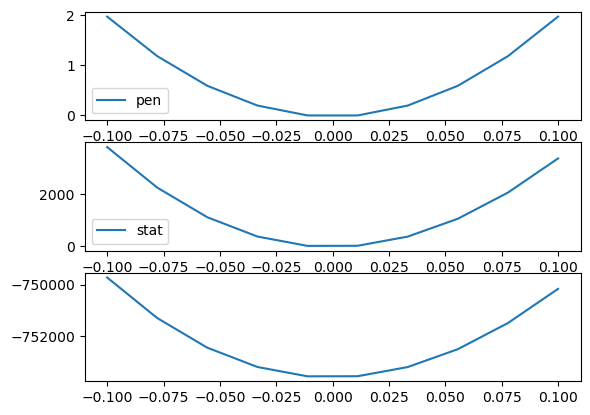

In [19]:
fig, ax = plt.subplots(3,1)
ax[0].plot(values, pen - np.min(pen), label= 'pen')
ax[1].plot(values, stat - np.min(stat), label= 'stat')
ax[2].plot(values, stat +pen , label= 'stat +pen')

ax[1].legend()
ax[0].legend()

In [22]:
dataset_pos_N.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str18,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3003e+00,,6.182e-02,nan,nan,False,False,False,
spectral,amplitude,1.1152e-12,cm-2 s-1 TeV-1,1.343e-13,nan,nan,False,True,False,
spectral,amplitude_nuisance,1.0000e-01,,7.320e-02,-2.000e-01,2.000e-01,False,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,


<AxesSubplot: >

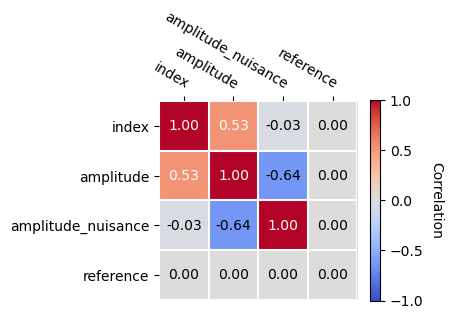

In [26]:
dataset_pos_N.models[0].spectral_model.covariance.plot_correlation()

In [43]:
cov =dataset_pos_N.models[0].spectral_model.covariance
print(cov)

[[ 3.82146137e-03  4.40734658e-15 -1.52018692e-04  0.00000000e+00]
 [ 4.40734658e-15  1.80392001e-26 -6.28801200e-15  0.00000000e+00]
 [-1.52018692e-04 -6.28801200e-15  5.35787925e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


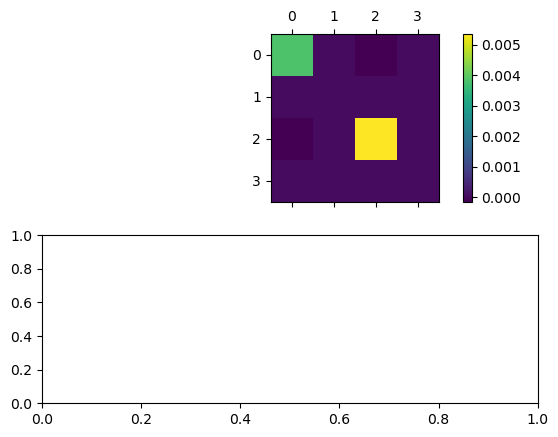

In [42]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(cov)  # interpolation='nearest')
fig.colorbar(cax);